<a href="https://colab.research.google.com/github/hanan99/Voice-Classification/blob/main/feeling_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import librosa
import glob

from zipfile import ZipFile

from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, concatenate, LSTM, Bidirectional, Dropout, MaxPooling2D, AveragePooling2D, Flatten, Dense, Activation , Input
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model

import seaborn as sns

from google.colab import drive

In [ ]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!ls '/content/drive/My Drive/Neural Network/Sound'

result.csv  test.rar  test.zip	train.zip


In [ ]:
!unzip "/content/drive/My Drive/Neural Network/Sound/train.zip"

Archive:  /content/drive/My Drive/Neural Network/Sound/train.zip
   creating: train/
  inflating: train/0000MA.wav        
  inflating: train/0003MA.wav        
  inflating: train/0004MN.wav        
  inflating: train/0005FS.wav        
  inflating: train/0006MA.wav        
  inflating: train/0008FN.wav        
  inflating: train/0011MN.wav        
  inflating: train/0012FS.wav        
  inflating: train/0013FH.wav        
  inflating: train/0014FW.wav        
  inflating: train/0015MN.wav        
  inflating: train/0016FS.wav        
  inflating: train/0018MA.wav        
  inflating: train/0020FW.wav        
  inflating: train/0021MN.wav        
  inflating: train/0022MA.wav        
  inflating: train/0023FH.wav        
  inflating: train/0024MA.wav        
  inflating: train/0027MA.wav        
  inflating: train/0028MH.wav        
  inflating: train/0029MA.wav        
  inflating: train/0031MA.wav        
  inflating: train/0032FS.wav        
  inflating: train/0033MN.wav        
  i

In [ ]:
!unzip "/content/drive/My Drive/Neural Network/Sound/test.zip"

Archive:  /content/drive/My Drive/Neural Network/Sound/test.zip
   creating: test/
  inflating: test/2705F.wav          
  inflating: test/2707M.wav          
  inflating: test/2708F.wav          
  inflating: test/2710M.wav          
  inflating: test/2711M.wav          
  inflating: test/2712M.wav          
  inflating: test/2713M.wav          
  inflating: test/2714M.wav          
  inflating: test/2715M.wav          
  inflating: test/2720F.wav          
  inflating: test/2721M.wav          
  inflating: test/2722F.wav          
  inflating: test/2724F.wav          
  inflating: test/2725M.wav          
  inflating: test/2726M.wav          
  inflating: test/2727F.wav          
  inflating: test/2728M.wav          
  inflating: test/2729F.wav          
  inflating: test/2733M.wav          
  inflating: test/2734F.wav          
  inflating: test/2735M.wav          
  inflating: test/2736M.wav          
  inflating: test/2737F.wav          
  inflating: test/2738M.wav          
  inf

In [ ]:
traindata = []
with ZipFile('/content/drive/My Drive/Neural Network/Sound/train.zip', 'r') as zipObj:
  traindata = zipObj.namelist()


In [ ]:
print(len(traindata))

1995


In [ ]:
print(traindata[1])

train/0000MA.wav


In [ ]:
testdata = []
with ZipFile('/content/drive/My Drive/Neural Network/Sound/test.zip', 'r') as zipObj:
  testdata = zipObj.namelist()


testdata [1]

'test/2705F.wav'

In [ ]:
print(len(testdata ))

228


In [ ]:
df1 =  pd.read_csv(r'/content/drive/My Drive/Neural Network/Sound/result.csv', index_col=0)
df1.head()

,label
Id,
2705F,N
2707M,H
2708F,N
2710M,A
2711M,A


In [ ]:
data_dictionary = { "A": [1, 0, 0, 0, 0], "H": [0, 1, 0, 0, 0],
                   "S": [0, 0, 1, 0, 0], "W": [0, 0, 0, 1, 0],
                   "N": [0, 0, 0, 0, 1]}
y_train = []

for i in range (1, len(traindata)):
  y_train.append(data_dictionary[traindata[i][-5]])

y_train = np.asarray(y_train)
print(y_train[1])

[1 0 0 0 0]


In [ ]:
y_train.shape

(1994, 5)

In [ ]:
train_audio = []

for i  in range (1, len(traindata)):
  address = traindata[i]
  y, sr = librosa.load(address)
  mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=36).T,axis=0)
  train_audio.append(mfcc)


train_audio = np.array(train_audio)
train_audio.shape

(1994, 36)

In [ ]:
test_audio = []
for i  in range (1, len(testdata)):
  address = testdata[i]
  y, sr = librosa.load(address)
  mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=36).T,axis=0)
  test_audio.append(mfcc)


test_audio = np.array(test_audio)
test_audio = test_audio.reshape((len(testdata)-1, 36, 1))
test_audio = np.asarray(test_audio)

In [ ]:
test_audio.shape

(227, 36, 1)

In [ ]:
y_test = df1['label']

for i in range (len(y_test)):

  y_test[i] = data_dictionary[y_test[i]]

y_test[1]


[0, 1, 0, 0, 0]

In [ ]:
test_audio = np.asarray(test_audio)
y_test = np.asarray(y_test)

y_test.shape

(227,)

In [ ]:
train_audio = train_audio.reshape(1994, 36, 1)
train_audio = np.asarray(train_audio)
y_train = np.asarray(y_train)

train_audio.shape


(1994, 36, 1)

In [ ]:
y_train.shape

(1994, 5)

In [ ]:
model1 = Sequential()
model1.add(Bidirectional(LSTM(36, return_sequences=True, activation = 'tanh'), input_shape = (36, 1)))
model1.add(Bidirectional(LSTM(36, activation = 'tanh')))

model1.add(Dense(36, activation='tanh'))
model1.add(Dense(18, activation='tanh'))
model1.add(Dense(12, activation='tanh'))
model1.add(Dense(5, activation='softmax'))

model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 36, 72)            10944     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 72)                31392     
_________________________________________________________________
dense (Dense)                (None, 36)                2628      
_________________________________________________________________
dense_1 (Dense)              (None, 18)                666       
_________________________________________________________________
dense_2 (Dense)              (None, 12)                228       
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 65        
Total params: 45,923
Trainable params: 45,923
Non-trainable params: 0
____________________________________________________

In [ ]:
model1.compile(optimizer = 'adam', loss='categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
history1 = model1.fit(x = train_audio,  y = y_train, epochs = 100, batch_size = 128)

Epoch 1/100
16/16 [==============================] - 11s 14ms/step - loss: 1.4788 - accuracy: 0.4427
Epoch 2/100
16/16 [==============================] - 0s 14ms/step - loss: 1.2078 - accuracy: 0.5836
Epoch 3/100
16/16 [==============================] - 0s 13ms/step - loss: 1.1360 - accuracy: 0.6086
Epoch 4/100
16/16 [==============================] - 0s 14ms/step - loss: 1.0903 - accuracy: 0.6302
Epoch 5/100
16/16 [==============================] - 0s 13ms/step - loss: 1.0878 - accuracy: 0.6177
Epoch 6/100
16/16 [==============================] - 0s 14ms/step - loss: 1.0366 - accuracy: 0.6487
Epoch 7/100
16/16 [==============================] - 0s 14ms/step - loss: 1.0122 - accuracy: 0.6565
Epoch 8/100
16/16 [==============================] - 0s 12ms/step - loss: 1.0032 - accuracy: 0.6451
Epoch 9/100
16/16 [==============================] - 0s 13ms/step - loss: 0.9830 - accuracy: 0.6670
Epoch 10/100
16/16 [==============================] - 0s 13ms/step - loss: 0.9597 - accuracy: 0.665

In [ ]:
model1.evaluate(train_audio, y_train)

63/63 [==============================] - 2s 6ms/step - loss: 0.0954 - accuracy: 0.9845


[0.0954328328371048, 0.9844533801078796]

In [ ]:
def emotion(lists) :
    data_dictionary = {0 : 'Angry', 1 : 'Neutral', 2 : 'Happy', 3 : 'Sad', 4 : 'Wondered'}
    index = lists.argmax()
    return data_dictionary[index]

In [ ]:
predictions = model1.predict(train_audio)
real = np.array(y_train).copy()

confusion_matrix1 = []
confusion_matrix2 = []

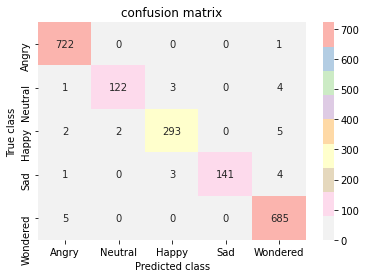

In [ ]:
for i in range(1994) :
    confusion_matrix1.append(emotion(real[i]))
    confusion_matrix2.append(emotion(predictions[i]))



confusion_matrix1 = np.asarray(confusion_matrix1)
confusion_matrix2 = np.asarray(confusion_matrix2)


LABELS=["Angry", "Neutral", "Happy", "Sad", "Wondered"]

conf_matrix = confusion_matrix(confusion_matrix1, confusion_matrix2, labels=LABELS)

sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", cmap="Pastel1_r")
plt.title("confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [ ]:
model2 = Sequential()
model2.add(Bidirectional(LSTM(36, return_sequences=True, activation = 'tanh'), input_shape = (36, 1)))
model2.add(Bidirectional(LSTM(36, activation = 'tanh')))

model2.add(Dense(18, activation='tanh'))
model2.add(Dense(12, activation='tanh'))
model2.add(Dense(5, activation='softmax'))

model2.compile(optimizer = 'sgd', loss='categorical_crossentropy', metrics = ['accuracy'])
model2.summary()


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_10 (Bidirectio (None, 36, 72)            10944     
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 72)                31392     
_________________________________________________________________
dense_16 (Dense)             (None, 18)                1314      
_________________________________________________________________
dense_17 (Dense)             (None, 12)                228       
_________________________________________________________________
dense_18 (Dense)             (None, 5)                 65        
Total params: 43,943
Trainable params: 43,943
Non-trainable params: 0
_________________________________________________________________


In [ ]:


history2 = model2.fit(x = train_audio,  y = y_train, epochs = 100, batch_size = 128)

Epoch 1/100
16/16 [==============================] - 5s 13ms/step - loss: 1.6048 - accuracy: 0.3037
Epoch 2/100
16/16 [==============================] - 0s 12ms/step - loss: 1.4783 - accuracy: 0.3917
Epoch 3/100
16/16 [==============================] - 0s 11ms/step - loss: 1.4038 - accuracy: 0.5288
Epoch 4/100
16/16 [==============================] - 0s 12ms/step - loss: 1.3532 - accuracy: 0.5454
Epoch 5/100
16/16 [==============================] - 0s 13ms/step - loss: 1.3241 - accuracy: 0.5445
Epoch 6/100
16/16 [==============================] - 0s 14ms/step - loss: 1.3216 - accuracy: 0.5244
Epoch 7/100
16/16 [==============================] - 0s 13ms/step - loss: 1.2907 - accuracy: 0.5408
Epoch 8/100
16/16 [==============================] - 0s 12ms/step - loss: 1.2704 - accuracy: 0.5427
Epoch 9/100
16/16 [==============================] - 0s 11ms/step - loss: 1.2559 - accuracy: 0.5447
Epoch 10/100
16/16 [==============================] - 0s 11ms/step - loss: 1.2387 - accuracy: 0.5492

In [ ]:
model2.evaluate(train_audio, y_train)

63/63 [==============================] - 1s 6ms/step - loss: 1.0730 - accuracy: 0.6244


[1.0730223655700684, 0.6243731379508972]

In [ ]:
predictions = model2.predict(train_audio)
real = np.array(y_train).copy()

confusion_matrix1 = []
confusion_matrix2 = []

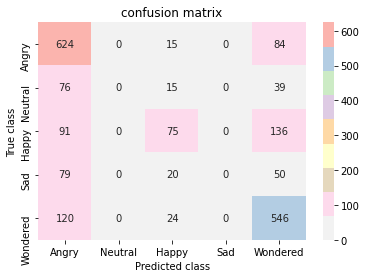

In [ ]:
for i in range(1994) :
    confusion_matrix1.append(emotion(real[i]))
    confusion_matrix2.append(emotion(predictions[i]))



confusion_matrix1 = np.asarray(confusion_matrix1)
confusion_matrix2 = np.asarray(confusion_matrix2)


LABELS=["Angry", "Neutral", "Happy", "Sad", "Wondered"]

conf_matrix = confusion_matrix(confusion_matrix1, confusion_matrix2, labels=LABELS)

sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", cmap="Pastel1_r")
plt.title("confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [ ]:
model3 = Sequential()
model3.add(Bidirectional(LSTM(36, return_sequences=True, activation = 'tanh'), input_shape = (36, 1)))
model3.add(Bidirectional(LSTM(36, activation = 'tanh')))

model3.add(Dense(18, activation='tanh'))
model3.add(Dense(12, activation='tanh'))
model3.add(Dense(5, activation='softmax'))

model3.compile(optimizer = 'rmsprop', loss='categorical_crossentropy', metrics = ['accuracy'])

model3.summary()


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_12 (Bidirectio (None, 36, 72)            10944     
_________________________________________________________________
bidirectional_13 (Bidirectio (None, 72)                31392     
_________________________________________________________________
dense_19 (Dense)             (None, 18)                1314      
_________________________________________________________________
dense_20 (Dense)             (None, 12)                228       
_________________________________________________________________
dense_21 (Dense)             (None, 5)                 65        
Total params: 43,943
Trainable params: 43,943
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history3 = model3.fit(x = train_audio,  y = y_train, epochs = 100, batch_size = 128)

Epoch 1/100
16/16 [==============================] - 5s 14ms/step - loss: 1.3969 - accuracy: 0.4314
Epoch 2/100
16/16 [==============================] - 0s 13ms/step - loss: 1.1536 - accuracy: 0.5928
Epoch 3/100
16/16 [==============================] - 0s 13ms/step - loss: 1.1211 - accuracy: 0.6181
Epoch 4/100
16/16 [==============================] - 0s 13ms/step - loss: 1.0762 - accuracy: 0.6220
Epoch 5/100
16/16 [==============================] - 0s 13ms/step - loss: 1.0558 - accuracy: 0.6285
Epoch 6/100
16/16 [==============================] - 0s 13ms/step - loss: 1.0812 - accuracy: 0.6131
Epoch 7/100
16/16 [==============================] - 0s 13ms/step - loss: 1.0445 - accuracy: 0.6276
Epoch 8/100
16/16 [==============================] - 0s 13ms/step - loss: 1.0210 - accuracy: 0.6373
Epoch 9/100
16/16 [==============================] - 0s 13ms/step - loss: 0.9971 - accuracy: 0.6447
Epoch 10/100
16/16 [==============================] - 0s 13ms/step - loss: 0.9986 - accuracy: 0.6552

In [ ]:
model3.evaluate(train_audio, y_train)

63/63 [==============================] - 1s 6ms/step - loss: 0.4005 - accuracy: 0.8541


[0.40046364068984985, 0.8540621995925903]

In [ ]:
predictions = model3.predict(train_audio)
real = np.array(y_train).copy()

confusion_matrix1 = []
confusion_matrix2 = []

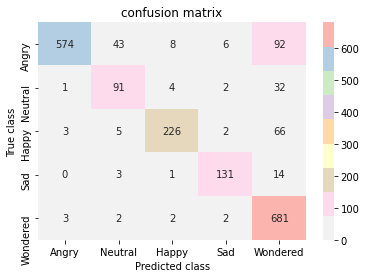

In [ ]:
for i in range(1994) :
    confusion_matrix1.append(emotion(real[i]))
    confusion_matrix2.append(emotion(predictions[i]))



confusion_matrix1 = np.asarray(confusion_matrix1)
confusion_matrix2 = np.asarray(confusion_matrix2)


LABELS=["Angry", "Neutral", "Happy", "Sad", "Wondered"]

conf_matrix = confusion_matrix(confusion_matrix1, confusion_matrix2, labels=LABELS)

sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", cmap="Pastel1_r")
plt.title("confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

We get better result with adam optimizer.